# Computational Neuroscience Final Project
## Elizabeth Frey

For this project, I used the following resources:
* [Dataset](https://www.kaggle.com/datasets/rajnathpatel/multilingual-spam-data)
* ChatGPT: See Chat GPT Prompts and Responses Document
* [Keras Model Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)
* [GRU Layer Tutorial](https://pythonalgos.com/2022/01/02/build-a-gru-rnn-in-keras/): Note, I implemented this in the `tutorial.ipynb` file and then used its format as a guideline
* [Skip Thought Vector Libraries and Example](https://pypi.org/project/skip-thoughts/)
* [Sentence Transformers](https://github.com/UKPLab/sentence-transformers)

In [ ]:
%pip install -r requirements.txt

## Import Data

In [55]:
import pandas as pd
import numpy as np

# read csv file
df = pd.read_csv('data-en-hi-de-fr.csv')

In [ ]:
from tensorflow.keras.utils import to_categorical

# create a dictionary of the languages
languages = {'en': 0, 'hi': 1, 'de': 2, 'fr': 3}

# group the dataframe by labels column
grouped = df.groupby('labels')

# create two dataframes, one for ham and one for spam
original_df = df
ham_df = grouped.get_group('ham')
spam_df = grouped.get_group('spam')


def processDf(df):
    df.drop('labels', axis=1, inplace=True)
    df.rename(columns={'text': 'en', 'text_hi': 'hi',
              'text_de': 'de', 'text_fr': 'fr'}, inplace=True)
    df = df.melt(var_name='language', value_name='phrase')
    df['language_code'] = df['language'].map(languages)
    return df


original_df = processDf(original_df)
ham_df = processDf(ham_df)
spam_df = processDf(spam_df)

## Creating Functions

### Embeddings

In [9]:

# define a function to tokenize the phrases in each dataframe

def tokenizeDf(df):
    tokens = [phrase.split() for phrase in df['phrase']]
    df['tokens'] = tokens
    return df

#### Word2Vec Embeddings

In [10]:
import gensim
from gensim.models import Word2Vec


def addWord2VecEmbeddingsFromTokens(df):
    # train the word2vec model on the tokens
    model = Word2Vec(df['tokens'], min_count=1)
    # create the embeddings for each dataframe
    df['w2v_embedding_from_tokens'] = df['tokens'].apply(
        lambda x: model.wv[x].mean(axis=0).astype(np.float32))
    return df

#### Skip-Thought Embeddings

<mark>This was a failure because of Python Version mismatches (this was written in Python 2.7). I was quite sad when this didn't work because from my research, the representations could be a an interesting point of comparison to analyze a unsupervised, generic distributed sentence encoder. Alas, I will try another type. </mark>

In [12]:
# %%sh
# # Directory to download the pretrained models to.
# mkdir skip_thoughts
# cd skip_thoughts

# wget http://www.cs.toronto.edu/~rkiros/models/dictionary.txt
# wget http://www.cs.toronto.edu/~rkiros/models/utable.npy
# wget http://www.cs.toronto.edu/~rkiros/models/btable.npy
# wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz
# wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz.pkl
# wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz
# wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz.pkl

# cd -

In [13]:
# import skipthoughts

# def createSkipThoughtEmbeddings(df):
#     model = skipthoughts.load_model()
#     encoder = skipthoughts.Encoder(model)
#     df['skip_thought_embedding'] = df['tokens'].apply(
#         lambda x: encoder.encode(x).astype(np.float32))
#     return df

#### Multilingual Embeddings

I wanted to try these out because they had different embeddings for different languages, and I'm curious as to which ones perform the best. 

In [109]:
from transformers import AutoTokenizer


def addEnglishBERTEmbeddings(df):
    modelName = 'bert-base-uncased'

    # Load model directly from Huggingface
    tokenizer = AutoTokenizer.from_pretrained(modelName)

    # create the embeddings for each dataframe
    df['english_bert_embedding'] = df['phrase'].apply(
        lambda x: tokenizer.encode(x, padding='max_length',
                                   max_length=100, return_tensors='np', truncation=True).mean(axis=0).astype(np.float32))

    return df


def addHindiBERTEmbeddings(df):
    modelName = 'monsoon-nlp/hindi-bert'

    # Load model directly from Huggingface
    tokenizer = AutoTokenizer.from_pretrained(modelName)

    # create the embeddings for each dataframe
    df['hindi_bert_embedding'] = df['phrase'].apply(
        lambda x: tokenizer.encode(x, padding='max_length',
                                   max_length=100, return_tensors='np', truncation=True).mean(axis=0).astype(np.float32))

    return df


def addFrenchBERTEmbeddings(df):
    modelName = 'baayematar/bert-french'

    # Load pretrained model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        modelName, do_lowercase=False)

    # create the embeddings for each dataframe
    df['french_bert_embedding'] = df['phrase'].apply(
        lambda x: tokenizer.encode(x, padding='max_length',
                                   max_length=100, return_tensors='np', truncation=True).mean(axis=0).astype(np.float32))

    return df


def addGermanBERTEmbeddings(df):
    modelName = 'bert-base-german-cased'

    # load pretrained tokenizeer
    tokenizer = AutoTokenizer.from_pretrained(modelName)

    # create the embeddings for each dataframe
    df['german_bert_embedding'] = df['phrase'].apply(
        lambda x: tokenizer.encode(x, padding='max_length',
                                   max_length=100, return_tensors='np', truncation=True).mean(axis=0).astype(np.float32))

    return df

### Train the Model

#### Create Training and Testing Data Functions

In [72]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

listOfEmbeddings = ['w2v_embedding_from_tokens', 'english_bert_embedding',
                    'french_bert_embedding', 'german_bert_embedding', 'hindi_bert_embedding']

# Create Training and Testing Data Functions


def createTrainingTestingData(embeddingType, df):
    if embeddingType not in listOfEmbeddings:
        print('Invalid embedding type')
        return

    X = df[embeddingType]
    y = df['language_code']

    # create the training and testing dataframes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    y_train_one_hot = to_categorical(y_train, 4)
    y_test_one_hot = to_categorical(y_test, 4)

    # convert the training and testing dataframes to numpy arrays
    X_train = np.array([x for x in X_train])
    X_test = np.array([x for x in X_test])
    y_train = np.array([y for y in y_train_one_hot])
    y_test = np.array([y for y in y_test_one_hot])

    # reshape the training and testing dataframes
    X_train = X_train.reshape(X_train.shape[0], 1, 100)
    X_test = X_test.reshape(X_test.shape[0], 1, 100)

    # Assuming X_train and y_train are NumPy arrays
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    return X_train, X_test, y_train, y_test

#### Create Model Function

In [12]:
from tensorflow import keras
from tensorflow.keras import layers


def createModel():
    model = keras.Sequential()
    model.add(layers.GRU(64, input_shape=(1, 100)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units=4, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer="adam",
        metrics=["accuracy"],
    )
    return model

#### Fit the Model using Training Data Function

In [111]:
def trainModel(model, X_train, y_train):
    model.fit(
        X_train, y_train, batch_size=64, epochs=10, verbose=0
    )
    return model

### Test the Model

#### Function to print ten random predictions

In [14]:
def printTenPredictions(model, X_test, y_test):
    for i in range(10):
        result = tf.argmax(model.predict(tf.expand_dims(X_test[i], 0)), axis=1)
        print(result.numpy(), y_test[i])

### Evalute the Model

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def evaluateModel(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = tf.argmax(y_test, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap using seaborn
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=languages.keys(), yticklabels=languages.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Print other metrics
    print('Accuracy:', tf.keras.metrics.Accuracy()(y_test, y_pred).numpy())
    print('Precision:', tf.keras.metrics.Precision()(y_test, y_pred).numpy())
    print('Recall:', tf.keras.metrics.Recall()(y_test, y_pred).numpy())

## Evaluate Model

### Testing Different Embeddings

#### Word2Vec

In [132]:
def word2Vec(df):
    df = tokenizeDf(df)
    df = addWord2VecEmbeddingsFromTokens(df)
    X_train, X_test, y_train, y_test = createTrainingTestingData(
        'w2v_embedding_from_tokens', df)
    model = createModel()
    model = trainModel(model, X_train, y_train)
    evaluateModel(model, X_test, y_test)

********** Original **********
140/140 [==============================] - 0s 1ms/step


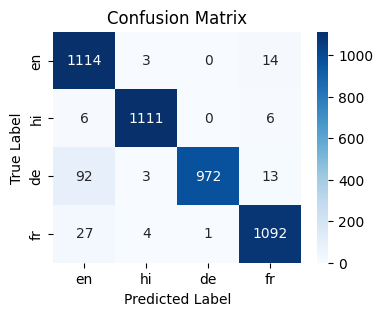

Accuracy: 0.9620906
Precision: 0.99471885
Recall: 0.9624286


In [133]:
print('********** Original **********')
word2Vec(original_df)

********** Ham **********
121/121 [==============================] - 0s 567us/step


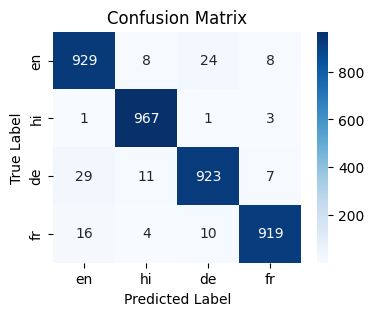

Accuracy: 0.9683938
Precision: 0.9861352
Recall: 0.98408854


In [140]:
print('********** Ham **********')
word2Vec(ham_df)

********** Spam **********
19/19 [==============================] - 0s 959us/step


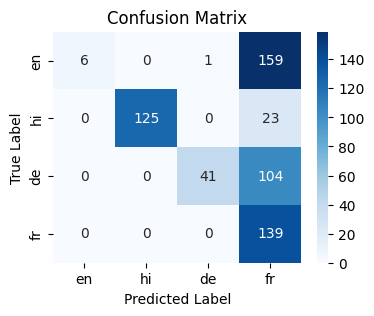

Accuracy: 0.5200669
Precision: 0.7297297
Recall: 1.0


In [134]:
print('********** Spam **********')
word2Vec(spam_df)

### BERT Embeddings


In [135]:
def runBert(df, language):
    if language == 'english':
        df = addEnglishBERTEmbeddings(df)
    elif language == 'hindi':
        df = addHindiBERTEmbeddings(df)
    elif language == 'french':
        df = addFrenchBERTEmbeddings(df)
    elif language == 'german':
        df = addGermanBERTEmbeddings(df)
    else:
        print('Invalid language')
        return

    embedding = language + '_bert_embedding'
    X_train, X_test, y_train, y_test = createTrainingTestingData(
        embedding, df)

    model = createModel()
    model = trainModel(model, X_train, y_train)
    evaluateModel(model, X_test, y_test)

********** Original English BERT **********
140/140 [==============================] - 0s 574us/step


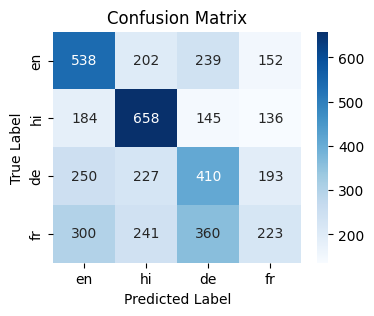

Accuracy: 0.41027367
Precision: 0.8138732
Recall: 0.7793808
********** Ham English BERT **********
121/121 [==============================] - 0s 1ms/step


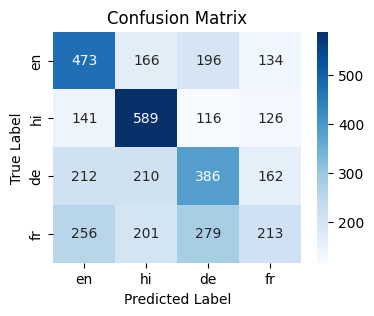

Accuracy: 0.43031088
Precision: 0.8214543
Recall: 0.7893462
********** Spam English BERT **********
19/19 [==============================] - 0s 631us/step


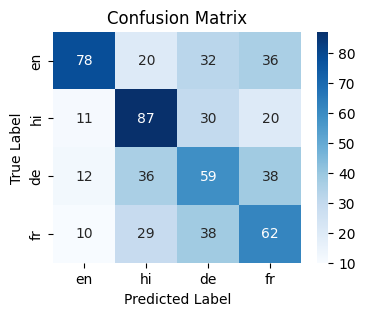

Accuracy: 0.47826087
Precision: 0.81930184
Recall: 0.9236111


In [141]:
print('********** Original English BERT **********')
runBert(original_df, 'english')
print('********** Ham English BERT **********')
runBert(ham_df, 'english')
print('********** Spam English BERT **********')
runBert(spam_df, 'english')

********** Original Hindi BERT **********
140/140 [==============================] - 0s 597us/step


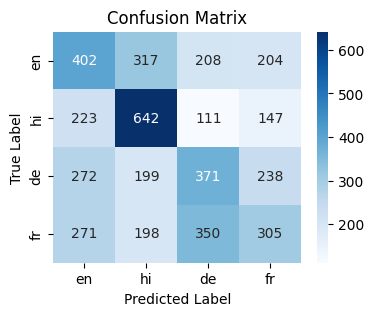

Accuracy: 0.38582325
Precision: 0.77841944
Recall: 0.7697626
********** Ham Hindi BERT **********
121/121 [==============================] - 0s 601us/step


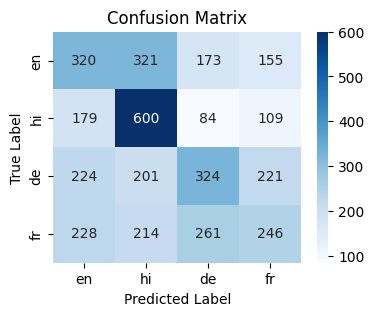

Accuracy: 0.38601035
Precision: 0.7768993
Recall: 0.78173643
********** Spam Hindi BERT **********
19/19 [==============================] - 0s 984us/step


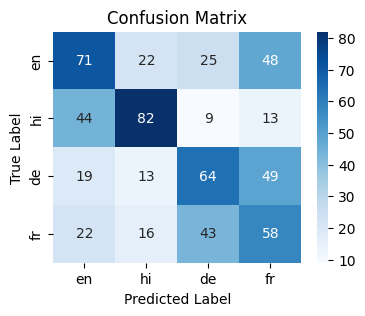

Accuracy: 0.45986623
Precision: 0.78506786
Recall: 0.8032407


In [142]:
print('********** Original Hindi BERT **********')
runBert(original_df, 'hindi')
print('********** Ham Hindi BERT **********')
runBert(ham_df, 'hindi')
print('********** Spam Hindi BERT **********')
runBert(spam_df, 'hindi')

********** Original French BERT **********
140/140 [==============================] - 0s 570us/step


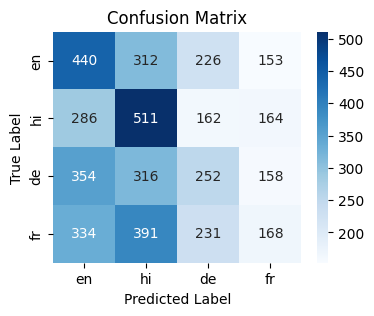

Accuracy: 0.30753702
Precision: 0.77299607
Recall: 0.70724374
********** Ham French BERT **********
121/121 [==============================] - 0s 581us/step


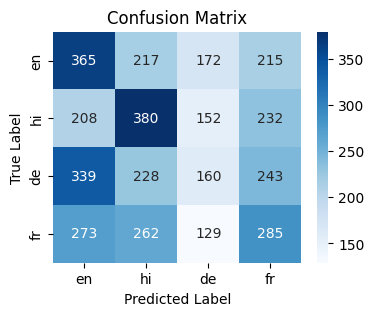

Accuracy: 0.30829015
Precision: 0.7742056
Recall: 0.7163611
********** Spam French BERT **********
19/19 [==============================] - 0s 663us/step


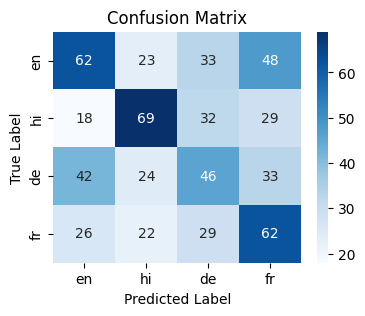

Accuracy: 0.39966556
Precision: 0.7688889
Recall: 0.8009259


In [143]:
print('********** Original French BERT **********')
runBert(original_df, 'french')
print('********** Ham French BERT **********')
runBert(ham_df, 'french')
print('********** Spam French BERT **********')
runBert(spam_df, 'french')

********** Original German BERT **********
140/140 [==============================] - 0s 606us/step


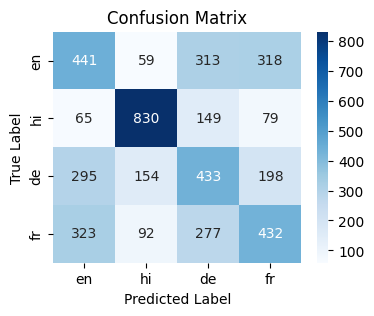

Accuracy: 0.4791386
Precision: 0.7930414
Recall: 0.7947099
********** Ham German BERT **********


In [144]:
print('********** Original German BERT **********')
runBert(original_df, 'german')
print('********** Ham German BERT **********')
runBert(ham_df, 'german')
print('********** Spam German BERT **********')
runBert(spam_df, 'german')